<a href="https://colab.research.google.com/github/YiFeng/Final_2020-Fall_NN/blob/main/Final_project_NN_pytorch_revised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import necessary packages

In [ ]:
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os.path as path
import seaborn as sns
from typing import List

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset

# load and preprocessing data

load data and preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# load data
work_dir: str = '/content/drive/My Drive/Yi_UCI_courses/2020 Fall/NN'
feature: pd.DataFrame = pd.read_csv(path.join(work_dir, 'features.csv'))
performance_10session: pd.DataFrame = pd.read_csv(path.join(work_dir, 'results_10session.csv'))
feature_name_list: List[str] = list(feature.columns)

In [ ]:
# standardadize feature data
from sklearn.preprocessing import MinMaxScaler
scaler: MinMaxScaler = MinMaxScaler()
features_std = scaler.fit_transform(feature)

convert to tensors

In [ ]:
# hyperparameters
DEVICE: torch.device = torch.device('cuda')
LEARNING_RATE: float = 1e-3
NUM_EPOCH: int = 300
batch_size: int = 17
number_folds: int = 5  # fold k times

In [ ]:
X = torch.tensor(features_std, device=DEVICE)
target = torch.tensor(performance_10session.values, device=DEVICE)
print(X.shape)
print(target.shape)
train_dataset = TensorDataset(X,target)

torch.Size([170, 18])
torch.Size([170, 10])


# Split to train, validation set

In [ ]:
def load_data_kfold(data, batch_size, k, n):
    # This function using functions in preprocessing.py to build dataset,
    # and then randomly split dataset with a fixed random seed.

    l = len(data)
    shuffle_dataset = True
    random_seed = 0  # fixed random seed (42)
    indices = list(range(l))

    if shuffle_dataset:
        np.random.seed(random_seed)
        np.random.shuffle(indices)  # shuffle
    # Collect indexes of samples for validation set.
    val_indices = indices[int(l / k) * n:int(l / k) * (n + 1)]
    # Collect indexes of samples for train set. Here the logic is that a sample
    # cannot in train set if already in validation set
    train_indices = list(set(indices).difference(set(val_indices)))
    # build Sampler
    train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
    valid_sampler = torch.utils.data.SubsetRandomSampler(val_indices)
    train_loader = DataLoader(data, batch_size=batch_size, sampler=train_sampler)  # build dataloader for train set
    validation_loader = DataLoader(data, batch_size=batch_size, sampler=valid_sampler)  # build dataloader for validate set
    return train_loader, validation_loader

# Create model

In [ ]:
# create MLP with one hidden layer
class MLPnet(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super(MLPnet, self).__init__()
    self.input_dim = input_dim
    self.dense1 = nn.Linear(input_dim, hidden_dim)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(.5)
    self.dense2 = nn.Linear(hidden_dim, output_dim)
  
  def forward(self, x):
    x = x.view(x.size(0), self.input_dim)
    x = self.dense1(x)
    x = self.relu(x)
    x = self.dropout(x)
    y2 = self.dense2(x)
    return y2

In [ ]:
class MLP_2hiddenlayer(torch.nn.Module):
  def __init__(self, input_dim, n1, n2, output_dim):
    super(MLP_2hiddenlayer, self).__init__()
    self.input_dim = input_dim
    self.dense1 = nn.Linear(input_dim, n1)
    self.relu1 = nn.ReLU()
    self.dropout = nn.Dropout(.5)
    self.dense2 = nn.Linear(n1, n2)
    self.relu2 = nn.ReLU()
    self.dense3 = nn.Linear(n2, output_dim)

  def forward(self, x):
    x = x.view(x.size(0), self.input_dim)
    x = self.dense1(x)
    y1 = self.relu1(x)
    y1 = self.dropout(y1)
    y2 = self.dense2(y1)
    y2 = self.relu2(y2)
    y3 = self.dense3(y2)
    return y3

In [ ]:
class MLP_3hiddenlayer(torch.nn.Module):
  def __init__(self, input_dim, n1, n2, n3, output_dim):
    super(MLP_3hiddenlayer, self).__init__()
    self.input_dim = input_dim
    self.dense1 = nn.Linear(input_dim, n1)
    self.relu1 = nn.ReLU()
    self.dense2 = nn.Linear(n1, n2)
    self.relu2 = nn.ReLU()
    self.dense3 = nn.Linear(n2, n3)
    self.relu3 = nn.ReLU()
    self.dense4 = nn.Linear(n3, output_dim)

  def forward(self, x):
    x = x.view(x.size(0), self.input_dim)
    x = self.dense1(x)
    y1 = self.relu1(x)
    y2 = self.dense2(y1)
    y2 = self.relu2(y2)
    y3 = self.dense3(y2)
    y3 = self.relu3(y3)
    y4 = self.dense4(y3)
    return y4

In [ ]:
class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):
        out = self.linear(x)
        return out

# train model

In [ ]:
# base linear regression model
model=linearRegression(18, 10).to(DEVICE).to(torch.double)
mse_loss = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

for epoch in range(NUM_EPOCH):
    # Converting inputs and labels to Variable
    inputs = X
    labels = target

    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    outputs = model(inputs)

    # get loss for the predicted output
    loss = mse_loss(outputs, labels)
    print(loss)
    # get gradients w.r.t to parameters
    loss.backward()

    # update parameters
    optimizer.step()

    print('epoch {}, loss {}'.format(epoch, loss.item()))


No. 0 Fold
minimum validation loss is 1.5509

No. 1 Fold
minimum validation loss is 0.9143

No. 2 Fold
minimum validation loss is 1.0000

No. 3 Fold
minimum validation loss is 1.2917

No. 4 Fold
minimum validation loss is 0.5736


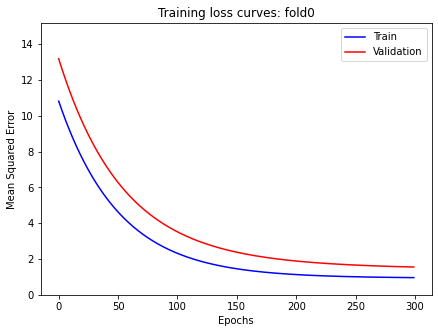

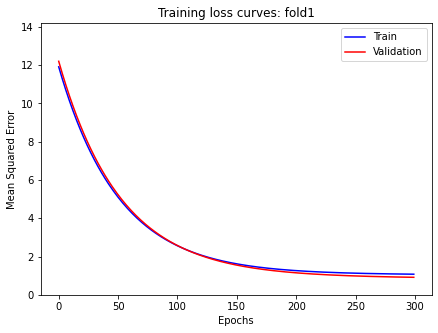

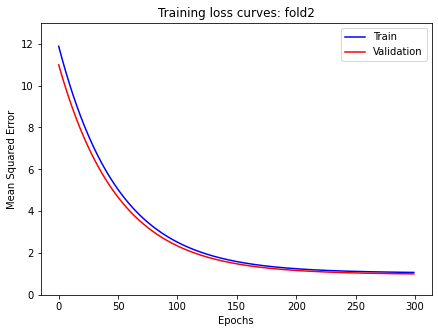

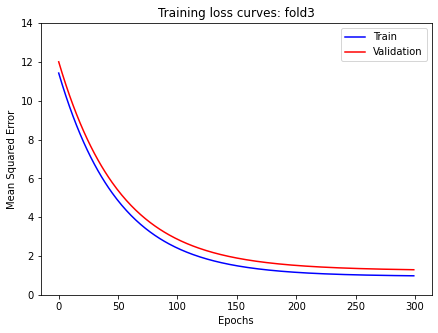

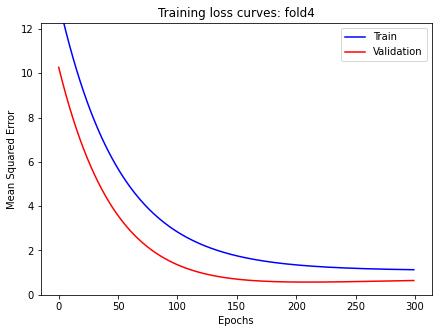

In [ ]:
train_loss_allfold = []
valid_loss_allfold = []
for n in range(number_folds):
    # Load data for current fold
    train_loader, validation_loader = load_data_kfold(train_dataset, batch_size, number_folds, n)
    print("\nNo.", n, "Fold")

    # model = MLPnet(18,10,10).to(DEVICE).to(torch.double)
    model = MLP_2hiddenlayer(18,20,12,10).to(DEVICE).to(torch.double)
    # model = MythirdNetwork(18,12,10,6,10).to(DEVICE).to(torch.double)
    # model = LinearRegressionModel().to(DEVICE).to(torch.double) 
  
    #loss function and optimizer
    mse_loss = torch.nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3) # weight_decay = 0.001

    # Start training for current fold
    valid_losses = []
    train_losses = []
    for epoch in range(NUM_EPOCH):
        start_time = time.time()
        model.train()
        # print('train_loader length={}, batch_size={}'.format(len(train_loader.dataset), train_loader.batch_size))
        num_batch = len(train_loader)

        train_loss = 0
        for batch_id, (batch_x, batch_y) in enumerate(train_loader):
            y_pred = model(batch_x)

            loss = mse_loss(y_pred, batch_y)
            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            elapsed_time = time.time() - start_time
            elapsed_min = int(elapsed_time / 60)
            elapsed_sec = elapsed_time - 60 * elapsed_min

            # print('\rEpoch:{} Batch:{}/{} Loss:{:.4f} Time:{}m{:.2f}s\n'.format(epoch + 1, batch_id, num_batch, loss.item(), elapsed_min, elapsed_sec), end='')
        
        #print("am i running?")
        train_loss /= num_batch
        train_losses.append(train_loss)

        model.eval()
        valid_loss = 0
        best_loss = 0.6 # np.inf
        num_batch = len(validation_loader)

        for batch_id, (batch_x, batch_y) in enumerate(validation_loader):
            y_pred = model(batch_x)
            loss = mse_loss(y_pred, batch_y)
            valid_loss += loss.item()

        valid_loss /= num_batch
        valid_losses.append(valid_loss)

        #save model when validation loss is minimum
        if valid_loss < best_loss:
            best_loss = valid_loss
            torch.save(model.state_dict(), 'mlp__regression.model')  

        # print('Valid Loss:{:.4f}'.format(valid_loss))
    
    train_loss_allfold.append(train_losses)
    valid_loss_allfold.append(valid_losses)
        #plot
    fig, ax = plt.subplots(figsize=(7,5))
    ax.plot(train_losses, 'blue')
    ax.plot(valid_losses, 'red')
    ax.set_title('Training loss curves: fold' + str(n))
    ax.set_ylim(0,max(valid_losses)+2)
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Mean Squared Error')
    ax.legend(['Train','Validation'])

    print('minimum validation loss is {:.4f}'.format(min(valid_losses)))

In [ ]:
df_train_loss = pd.DataFrame(train_loss_allfold).T
df_valid_loss = pd.DataFrame(valid_loss_allfold).T

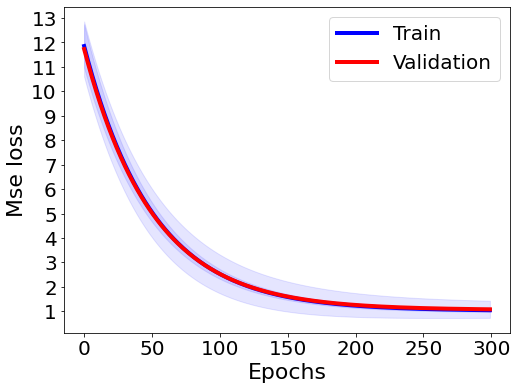

In [ ]:
# training curves average all folds
fig, ax = plt.subplots(figsize=(8,6))
df = [df_train_loss, df_valid_loss]
colors = ['blue', 'red']
for i in range(2):
  df_mean = df[i].mean(1)
  df_sd = df[i].std(1)
  t = pd.DataFrame({'mean': df_mean, 'sd': df_sd})
  x = range(NUM_EPOCH)
  y = t['mean']
  yerr = t['sd']
  # ci = 1.96 * np.std(y)/np.mean(y)
  label = str(i)
  ax.plot(x, y, color = colors[i],
              label=label, linewidth=4)
  ax.fill_between(x, (y+yerr), (y-yerr), color='b', alpha=.1)
  ax.set_xlabel('Epochs', fontsize=22)
  ax.set_ylabel('Mse loss', fontsize=22)
  # ax.set_title('cluster_using max, slope and sd', fontsize=28)
  # ax.set_xlim(1,501)
  ax.set_yticks(np.arange(1, 14, 1))
ax.tick_params(labelsize=20)
ax.legend(['Train','Validation'], fontsize=20)
# ax.legend()
fig.show()

# get sample data in each fold

In [ ]:
def get_sampled_dataframe(sampled_data_loader, part):
  sampled_data_set = sampled_data_loader.dataset.tensors[part].cpu()
  sampled_index = list(iter(sampled_data_loader.sampler))
  return pd.DataFrame(sampled_data_set.numpy()).loc[sampled_index]

In [ ]:
for n in range(5):
  train_loader, valid_loader = load_data_kfold(train_dataset, 5000, number_folds, n)
  df_valid_target = get_sampled_dataframe(valid_loader, 1)
  fig, ax = plt.subplots(figsize=(8,6))
  x = df_valid_target.columns
  ax.set_title('Traning trajectory')
  for index, row in df_valid_target.iterrows():
    y = row
    ax.plot(x, y, linewidth=2)
  plt.show()

# Prediction

In [ ]:
model.load_state_dict(torch.load('mlp__regression.model'))

<All keys matched successfully>

In [ ]:
model.to(DEVICE).to(torch.double)
y_pred = model(X)
y_pred = pd.DataFrame(y_pred.data.cpu().numpy())

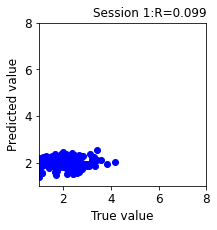

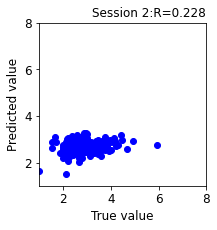

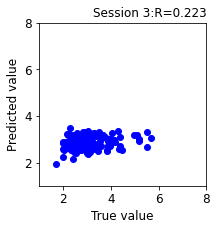

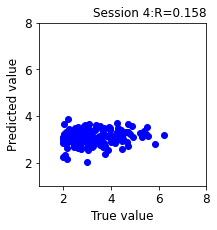

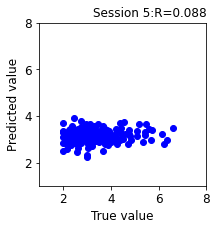

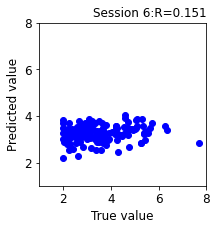

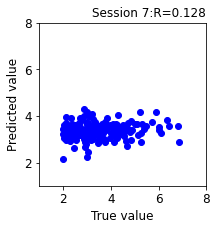

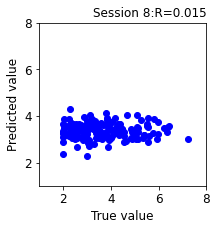

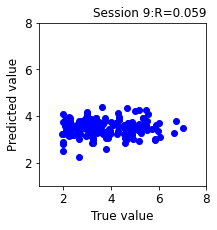

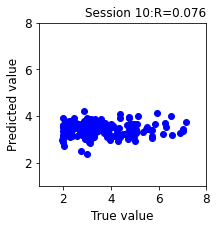

In [ ]:
for i in range (10):
  fig, ax = plt.subplots(figsize=(3,3))
  y = y_pred.iloc[:,i]
  x = performance_10session.iloc[:,i]
  ax.scatter(x,y,c='blue')
# ax.legend(fontsize=24, loc=4)
  ax.set_ylim(ymin=1, ymax=8)
  ax.set_xlim(xmin=1, xmax=8)
  ax.set_xlabel('True value', fontsize=12)
  ax.set_ylabel('Predicted value', fontsize=12)
  ax.tick_params(labelsize=12)
  correlation = 'R={:.3f}'.format(x.corr(y))
  ax.set_title('Session '+ str(i+1) +':' + correlation, loc='right', fontsize=12)
  plt.show()

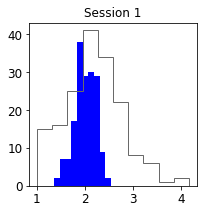

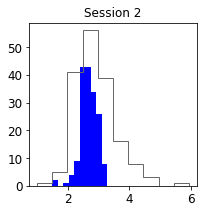

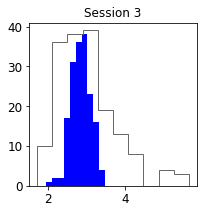

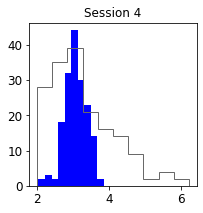

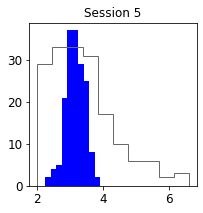

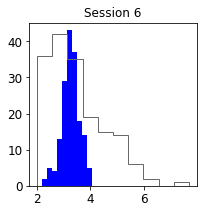

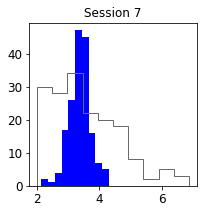

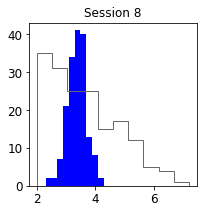

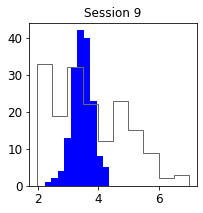

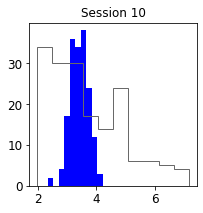

In [ ]:
for i in range (10):
  fig, ax = plt.subplots(figsize=(3,3))
  ax.hist(y_pred.iloc[:,i],histtype='stepfilled', color='blue', label='Prediction')
  ax.hist(performance_10session.iloc[:,i],histtype='step', color='dimgray', label='Target')
  # ax.set_xlabel('Value', fontsize=12)
  # ax.set_ylabel('Count', fontsize=12)
  ax.tick_params(labelsize=12)
  ax.set_title('Session '+ str(i+1), fontsize=12)
  # ax.legend(fontsize=10)
  plt.show()

# explain the model

In [ ]:
!pip install shap

In [ ]:
import shap
features = torch.tensor(features_std, device=DEVICE)
explainer=shap.DeepExplainer(model, features)
shap_values = explainer.shap_values(features)

In [ ]:
import pickle
with open(path.join(work_dir, "shap_values(10,6,10)"), mode='wb') as f:
  pickle.dump(shap_values, f)
  f.close()

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[9], shap_values[9], features_std, feature_name_list)

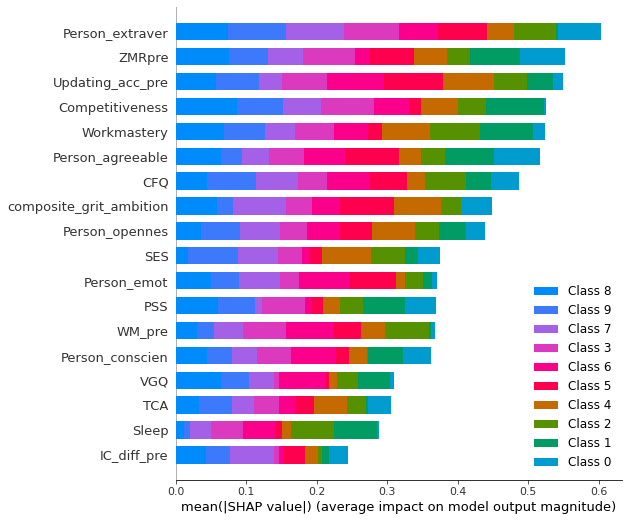

In [ ]:

shap.summary_plot(shap_values, features_std, feature_names=feature_name_list, cmap='BuPu')

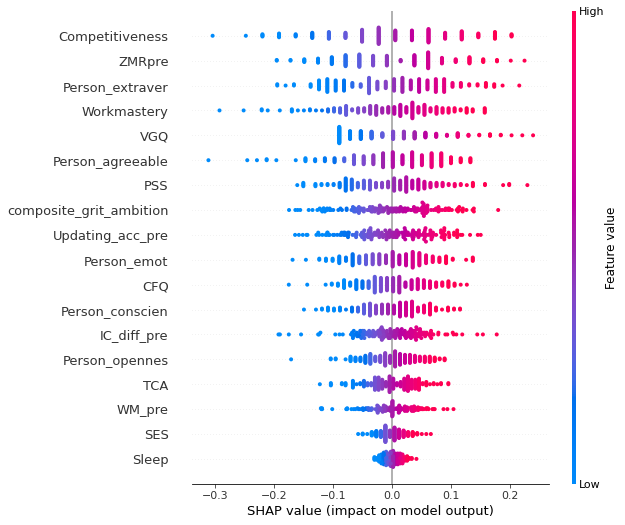

In [ ]:
shap.summary_plot(shap_values[8], features_std, feature_names=feature_name_list)